# Mosaicking

In [16]:
# Clean up
import os

os.system(f"rm *.log *.i{source_ms}.fits")
os.system(f"rm -rf {ms_filename}")


0

In [1]:
source_ms = 'ASKAPsim_Spectralline_Apr2010'
model_name = f'./data/{source_ms}'
ms_filename = f'{source_ms}.ms'

nchan = 48
frequency="1.420GHz"
increment="1MHz"

In [2]:

# ra ,dec = "08h16m36.24s -70d39m55.08s"
ra, dec = "19h39m25.0267s", "-63d42m45.6255s"

print(ra, dec)

direction=f"[{ra}, {dec}, J2000]"

19h39m25.0267s -63d42m45.6255s


In [5]:
# import matplotlib.pyplot as plt
# from astropy.io import fits
# from astropy.wcs import WCS

# from casatools import table

# tbl = table()
# tbl.open(model_name, nomodify=False)

# data=tbl.getcol("map")

# print(data.shape)
# data = data[:,:,:,1:49,:]
# print(data.shape)

# tbl.putcol("map", data)
# tbl.flush()

# tbl.close()

# del data


(1536, 1536, 1, 1024, 1)
(1536, 1536, 1, 48, 1)


## Simulating the Model

In [9]:
from taitale.askap.tools import csimulator
from taitale.askap.parsets import SourcesParset, SourceParset, WProjGridderParset
import os

os.system(f"rm -rf {ms_filename}")

gridder = WProjGridderParset(
    wmax=50000,
    nwplanes=257,
    oversample=3,
    maxsupport=4096,
    variablesupport=True,
    offsetsupport=True,
    sharecf=True,
)

sources = SourcesParset()

source = SourceParset(
        name="src1",
        direction="[12h30m00.000, -45.00.00.000, J2000]",
    )
source.add("comp1", 1.0, 2*u.arcsec, 2*u.arcsec, [1*u.arcsec, 1*u.arcsec, 0.5*u.arcsec])

source1 = SourceParset(name=source_ms, direction=direction, model=model_name)

sources.add_source()

csimulator(
    dataset=ms_filename,
    sources=sources,
    antennas="./parsets/ASKAP36.antpos.in",
    feeds="./parsets/ASKAP1feeds.in",
    duration_from="-1h",
    duration_to="1h",
    gridder=gridder,
    spw=f'[{nchan}, {frequency}, {increment}, "XX YY XY YX"]'
)


Starting csimulator
csimulator complete


## Imaging our Measurement Set

In [11]:
from taitale.askap.tools import imager

# Default parset for Clean used
imager(
    dataset = f"./{ms_filename}",
    imagename=f"image.i.{source_ms}",
    shape=[2048, 2048],
    cellsize=['10arcsec', '10arcsec'],
    direction=direction,
    gridder=gridder,
    workers=7,
    nchanpercore=24,
    solverpercore=True,
    restore=True,
    restore_beam="fit",
    restore_beam_cutoff= "0.5"
)

Starting imager


CalledProcessError: Command 'podman run --rm -w /home/yanda --user $UID:$GID -v $PWD:/home/yanda/ registry.gitlab.com/askapsdp/all_yandasoft:1.1.x-latest-slim mpiexec -n 7 imager -c cimager.in > imager-2021-12-17-14-42-01.log' returned non-zero exit status 139.

## Viewing our results

Filename: image.i.PKS-1934-638.taylor.0.restored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (2048, 2048, 1, 1)   float32   
None
Filename: psf.image.i.PKS-1934-638.taylor.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (2048, 2048, 1, 1)   float32   
None
Filename: weights.i.PKS-1934-638.taylor.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (2048, 2048, 1, 1)   float32   
None
Filename: image.i.PKS-1934-638.taylor.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (2048, 2048, 1, 1)   float32   
None


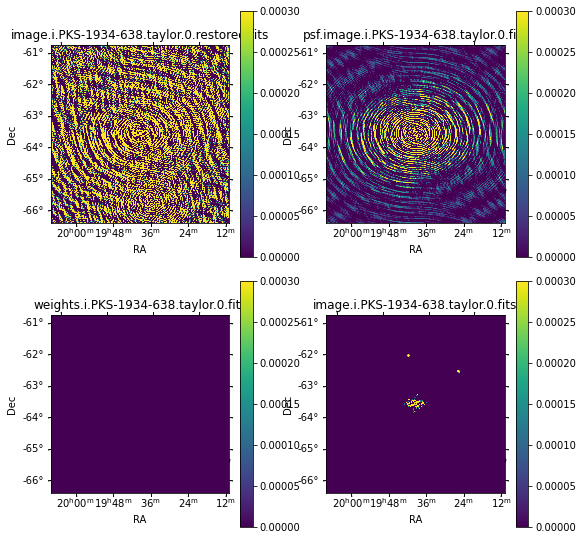

In [6]:
# Let's have a look at our image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

files = [
    f'image.i.{source_ms}.taylor.0.restored.fits',
    f'psf.image.i.{source_ms}.taylor.0.fits',
    f'weights.i.{source_ms}.taylor.0.fits',
    f'image.i.{source_ms}.taylor.0.fits',
]

# Using one of the files to setup WCS projection
hdu = fits.open(files[0])[0]

fig = plt.figure(figsize=(8, 8))
wcs = WCS(hdu.header, naxis=2)

for i in range(2):
    for j in range(2):
        idx = 2 * i + j
        if idx >= len(files):
            break
        file = files[idx]
        print(fits.info(file))
        hdu = fits.open(file)[0]

        ax = plt.subplot(2, 2, idx+1, projection=wcs)
        
        im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis', vmax=300e-6)
        
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.set_autoscale_on(False)
        ax.set_title(files[idx])
        plt.colorbar(im, ax=ax)

plt.tight_layout(pad=2.5, h_pad=1.4)
plt.show()


## Mosaicking

In [ ]:
from taitale.askap.tools import linmos

linmos(
    names=files,
    weighttype='Combined',
    outname='out.fits',
    outweight='out.weight.fits'
)

FromPrimaryBeamModel